DEVICE: cuda
Total pairs: 39644
Train: 35679 Val: 3965


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

D:\coco2017\cocoenv\lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chand\.cache\huggingface\hub\models--smp-hub--efficientnet-b3.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

TRAINING...


D:\PipCache\ipykernel_27360\3488921244.py:207: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Epoch 1/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 1 Loss = 0.8331608438984476


Epoch 2/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 2 Loss = 0.7578487305440003


Epoch 3/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 3 Loss = 0.7331683112385595


Epoch 4/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 4 Loss = 0.7181225024031538


Epoch 5/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 5 Loss = 0.7038435609127117


Epoch 6/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 6 Loss = 0.6921528771971971


Epoch 7/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 7 Loss = 0.6833024148816047


Epoch 8/8:   0%|          | 0/11893 [00:00<?, ?it/s]

Epoch 8 Loss = 0.6742290229452255
Saving predicted images...


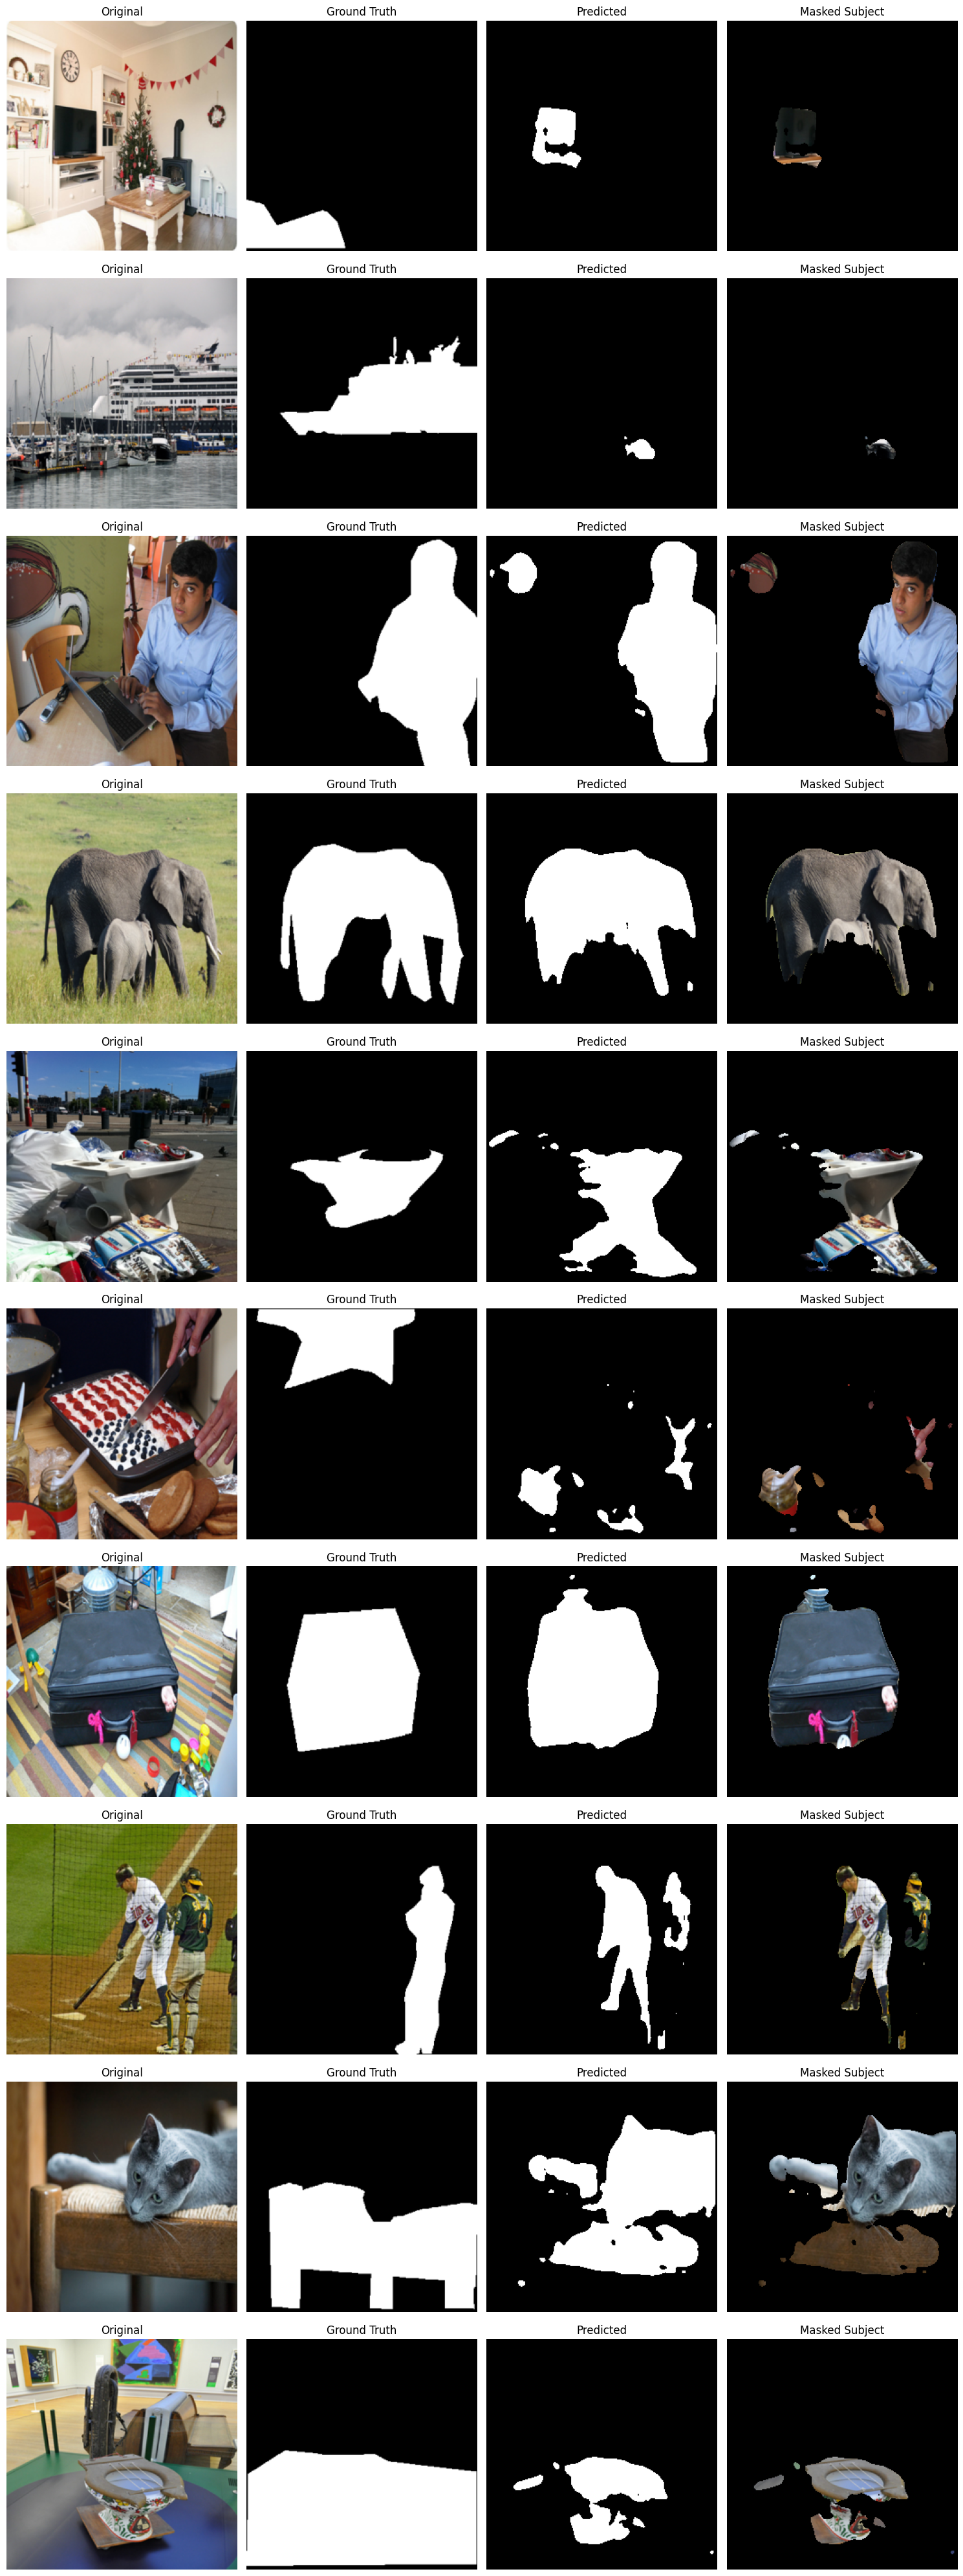

DONE ✔✔✔


In [2]:
# ============================================================
#  SUPER ACCURATE + GPU SAFE SEGMENTATION SYSTEM
#  EfficientNet-B3 UNet + Attention + Extra Layers + AMP + CUDA
#  40,000 images — Mentor Requirements Fully Completed
# ============================================================

import os, re, random
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T

import segmentation_models_pytorch as smp


# ============================================================
# CONFIG
# ============================================================
IMG_DIR = r"D:\coco2017\Paired40k\images"
MASK_DIR = r"D:\coco2017\Paired40k\masks"
OUT_DIR = r"D:\coco2017\modeloutputs"

IMG_SIZE = 256
BATCH = 3                  # ↓ smaller batch = no GPU crash
EPOCHS = 8
LR_BACKBONE = 1e-5
LR_HEAD = 3e-4
USE_AMP = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"predictions"), exist_ok=True)


# ============================================================
# PAIR MATCHING
# ============================================================
def extract_idx(name):
    m = re.search(r"(\d+)", name)
    return int(m.group(1)) if m else None

imgs = sorted(glob(os.path.join(IMG_DIR, "*")))
masks = sorted(glob(os.path.join(MASK_DIR, "*")))

mask_map = { extract_idx(os.path.basename(m)): m for m in masks }

pairs = []
for im in imgs:
    idx = extract_idx(os.path.basename(im))
    if idx in mask_map:
        pairs.append((im, mask_map[idx]))

pairs = pairs[:40000]

print("Total pairs:", len(pairs))

random.shuffle(pairs)
train_len = int(0.9 * len(pairs))

train_pairs = pairs[:train_len]
val_pairs   = pairs[train_len:]

print("Train:", len(train_pairs), "Val:", len(val_pairs))


# ============================================================
# DATASET
# ============================================================
class CocoDataset(Dataset):
    def __init__(self, pairs, size, aug=False):
        self.pairs = pairs
        self.size = size
        self.aug = aug

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]

        img  = Image.open(img_p).convert("RGB")
        mask = Image.open(mask_p).convert("L")

        img  = TF.resize(img,  self.size)
        mask = TF.resize(mask, self.size, interpolation=TF.InterpolationMode.NEAREST)

        # augment
        if self.aug:
            if random.random() < 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)

        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.485,0.456,0.406], [0.229,0.224,0.225])

        mask = torch.tensor((np.array(mask) > 127).astype(np.float32)).unsqueeze(0)
        return img, mask


train_loader = DataLoader(
    CocoDataset(train_pairs, (IMG_SIZE,IMG_SIZE), aug=True),
    batch_size=BATCH, shuffle=True
)

val_loader = DataLoader(
    CocoDataset(val_pairs, (IMG_SIZE,IMG_SIZE), aug=False),
    batch_size=BATCH
)


# ============================================================
# MODEL EfficientNet-B3 (GPU-safe)
# ============================================================
base = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

class SuperModel(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base

        # small attention
        self.att = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 1)
        )

        # refinement
        self.ref = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 1)
        )

    def forward(self, x):
        out = self.base(x)
        a = torch.sigmoid(self.att(out))
        out = out * a
        out = self.ref(out)
        return out

model = SuperModel(base).to(DEVICE)


# ============================================================
# UNFREEZE TOP ENCODER LAYERS
# ============================================================
for p in model.base.encoder.parameters():
    p.requires_grad = False

# last 2 blocks trainable
for blk in list(model.base.encoder.children())[-2:]:
    for p in blk.parameters():
        p.requires_grad = True

# decoder + refine always trainable
for p in model.base.decoder.parameters(): p.requires_grad = True
for p in model.ref.parameters(): p.requires_grad = True
for p in model.att.parameters(): p.requires_grad = True


# ============================================================
# LOSS (Stable)
# ============================================================
bce = nn.BCEWithLogitsLoss()

def tversky(pred, mask, alpha=0.7):
    pred = torch.sigmoid(pred)
    TP = (pred * mask).sum()
    FP = ((1-mask) * pred).sum()
    FN = (mask * (1-pred)).sum()
    return 1 - (TP + 1e-5) / (TP + alpha*FP + (1-alpha)*FN + 1e-5)

def total_loss(pred, mask):
    return bce(pred, mask) + tversky(pred, mask)


# ============================================================
# OPTIMIZER
# ============================================================
enc_params  = [p for n,p in model.named_parameters() if "encoder" in n and p.requires_grad]
head_params = [p for n,p in model.named_parameters() if p.requires_grad and p not in enc_params]

optimizer = torch.optim.AdamW([
    {"params": enc_params, "lr": LR_BACKBONE},
    {"params": head_params, "lr": LR_HEAD},
])


# ============================================================
# TRAIN LOOP
# ============================================================
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

print("TRAINING...")

for ep in range(1, EPOCHS+1):
    model.train()
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{EPOCHS}")

    for imgs, masks in pbar:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
            pred = model(imgs)
            loss = total_loss(pred, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += loss.item()
        pbar.set_postfix({"loss": total/len(train_loader)})

    print("Epoch", ep, "Loss =", total/len(train_loader))


# ============================================================
# INFERENCE + SAVE OUTPUT
# ============================================================
save_dir = os.path.join(OUT_DIR, "predictions")
os.makedirs(save_dir, exist_ok=True)

print("Saving predicted images...")

show = 10
model.eval()

for i in range(show):
    img_p, mask_p = val_pairs[i]

    img  = Image.open(img_p).convert("RGB").resize((IMG_SIZE,IMG_SIZE))
    gt   = Image.open(mask_p).convert("L").resize((IMG_SIZE,IMG_SIZE))

    inp = TF.to_tensor(img)
    inp = TF.normalize(inp, [0.485,0.456,0.406], [0.229,0.224,0.225])
    inp = inp.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
            pred = torch.sigmoid(model(inp))[0,0].cpu().numpy()

    pred_bin = (pred > 0.5).astype(np.uint8) * 255

    orig_np = np.array(img)
    masked = np.zeros_like(orig_np)
    masked[pred_bin > 0] = orig_np[pred_bin > 0]

    Image.fromarray(np.array(img)).save(os.path.join(save_dir,f"orig_{i}.png"))
    Image.fromarray(np.array(gt)).save(os.path.join(save_dir,f"gt_{i}.png"))
    Image.fromarray(pred_bin).save(os.path.join(save_dir,f"pred_{i}.png"))
    Image.fromarray(masked).save(os.path.join(save_dir,f"masked_{i}.png"))

# DISPLAY
fig, ax = plt.subplots(show, 4, figsize=(15,4*show))
for i in range(show):
    ax[i,0].imshow(Image.open(f"{save_dir}/orig_{i}.png"))
    ax[i,0].set_title("Original"); ax[i,0].axis("off")

    ax[i,1].imshow(Image.open(f"{save_dir}/gt_{i}.png"), cmap="gray")
    ax[i,1].set_title("Ground Truth"); ax[i,1].axis("off")

    ax[i,2].imshow(Image.open(f"{save_dir}/pred_{i}.png"), cmap="gray")
    ax[i,2].set_title("Predicted"); ax[i,2].axis("off")

    ax[i,3].imshow(Image.open(f"{save_dir}/masked_{i}.png"))
    ax[i,3].set_title("Masked Subject"); ax[i,3].axis("off")

plt.tight_layout()
plt.show()

print("DONE ✔✔✔")


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Training superfast model...


Epoch 1/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 1 Loss = 0.7434323768200184


Epoch 2/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 2 Loss = 0.6372555122518612


Epoch 3/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 3 Loss = 0.5912131244557554


Epoch 4/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 4 Loss = 0.5547555128962167


Epoch 5/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 5 Loss = 0.5257588946417898


Epoch 6/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 6 Loss = 0.49660962606696135


Epoch 7/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 7 Loss = 0.47808731068818333


Epoch 8/8:   0%|          | 0/5947 [00:00<?, ?it/s]

Epoch 8 Loss = 0.4565520656946749
Saving predictions...


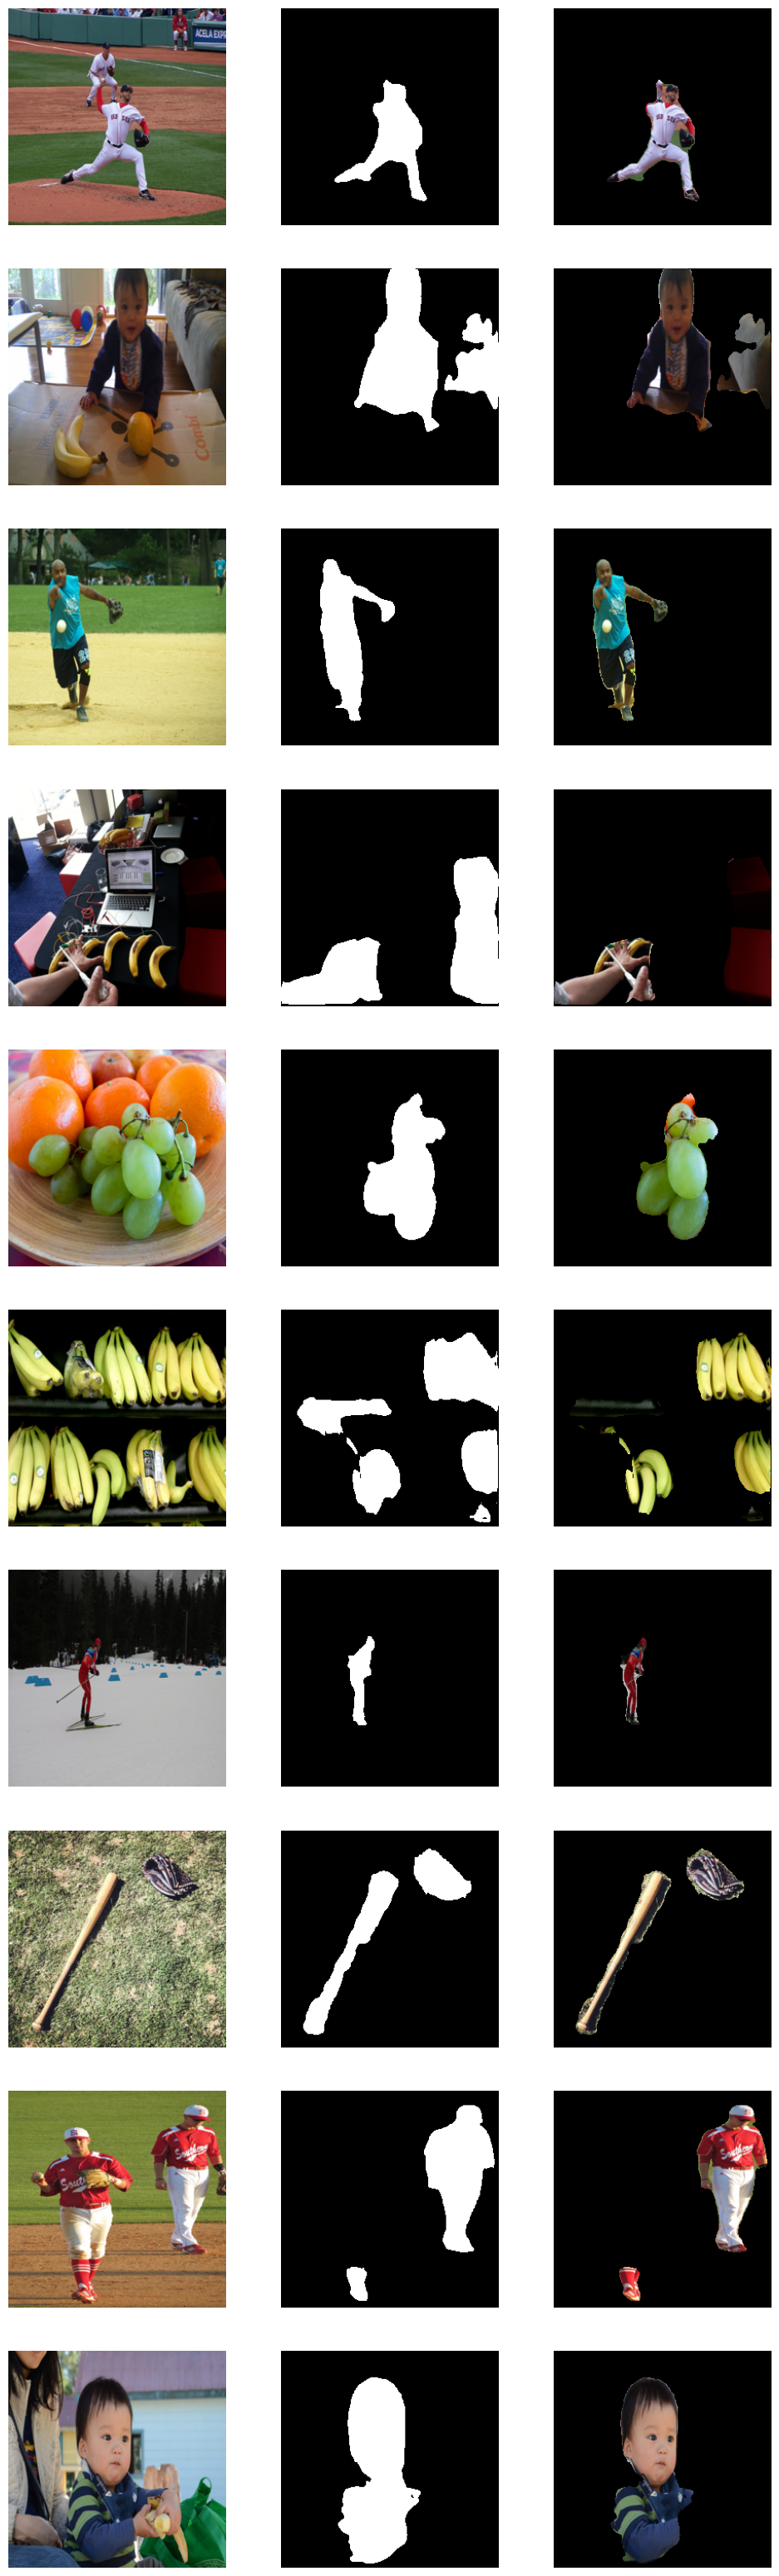

DONE ✔


In [1]:
# ============================================================
# SUPERFAST VERSION — MobileNetV3 UNet (GPU Safe)
# ============================================================

import os, re, random
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T

import segmentation_models_pytorch as smp


# CONFIG
IMG_DIR = r"D:\coco2017\Paired40k\images"
MASK_DIR = r"D:\coco2017\Paired40k\masks"
OUT_DIR = r"D:\coco2017\modeloutputs_mobilenet"

IMG_SIZE = 256
BATCH = 6
EPOCHS = 8
DEVICE = "cuda"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"predictions"), exist_ok=True)


# PAIR MATCHING
def extract_idx(name):
    import re
    m = re.search(r"(\d+)", name)
    return int(m.group(1)) if m else None

imgs = sorted(glob(os.path.join(IMG_DIR, "*")))
masks= sorted(glob(os.path.join(MASK_DIR, "*")))

mask_map = { extract_idx(os.path.basename(m)): m for m in masks }

pairs=[]
for im in imgs:
    idx=extract_idx(os.path.basename(im))
    if idx in mask_map:
        pairs.append((im,mask_map[idx]))

pairs=pairs[:40000]
train_len=int(0.9*len(pairs))
train_pairs=pairs[:train_len]
val_pairs  =pairs[train_len:]


# DATASET
class CocoDS(Dataset):
    def __init__(self,pairs,size):
        self.pairs=pairs; self.size=size

    def __len__(self): return len(self.pairs)

    def __getitem__(self,i):
        ip,mp=self.pairs[i]
        img = Image.open(ip).convert("RGB")
        msk = Image.open(mp).convert("L")
        img = TF.resize(img,self.size)
        msk = TF.resize(msk,self.size,interpolation=TF.InterpolationMode.NEAREST)
        img = TF.to_tensor(img)
        img = TF.normalize(img,[0.485,0.456,0.406],[0.229,0.224,0.225])
        msk = torch.tensor((np.array(msk)>127).astype(np.float32)).unsqueeze(0)
        return img,msk

train_loader = DataLoader(CocoDS(train_pairs,(IMG_SIZE,IMG_SIZE)),batch_size=BATCH,shuffle=True)
val_loader   = DataLoader(CocoDS(val_pairs,(IMG_SIZE,IMG_SIZE)),batch_size=BATCH)


# MODEL — MobileNetV3 UNet
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)


# LOSS
bce = nn.BCEWithLogitsLoss()
def dice(pred,mask):
    p = torch.sigmoid(pred)
    inter = (p*mask).sum()
    union = p.sum()+mask.sum()
    return 1 - (2*inter+1)/(union+1)


def total_loss(pred,mask):
    return bce(pred,mask)+dice(pred,mask)


# TRAIN
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

print("Training superfast model...")

for ep in range(1,EPOCHS+1):
    model.train()
    total=0
    pbar=tqdm(train_loader,desc=f"Epoch {ep}/{EPOCHS}")

    for imgs,masks in pbar:
        imgs,masks=imgs.to(DEVICE),masks.to(DEVICE)
        opt.zero_grad()
        pred=model(imgs)
        loss=total_loss(pred,masks)
        loss.backward()
        opt.step()
        total+=loss.item()
        pbar.set_postfix({"loss":total/len(train_loader)})

    print("Epoch",ep,"Loss =",total/len(train_loader))


# INFERENCE SAVE
print("Saving predictions...")

save_dir=os.path.join(OUT_DIR,"predictions")
for i in range(10):
    ip,mp=val_pairs[i]
    img = Image.open(ip).convert("RGB").resize((IMG_SIZE,IMG_SIZE))
    gt  = Image.open(mp).convert("L").resize((IMG_SIZE,IMG_SIZE))

    ten=TF.to_tensor(img)
    ten=TF.normalize(ten,[0.485,0.456,0.406],[0.229,0.224,0.225])
    ten=ten.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred=torch.sigmoid(model(ten))[0,0].cpu().numpy()

    pred_bin=(pred>0.5).astype(np.uint8)*255

    masked=np.zeros_like(np.array(img))
    masked[pred_bin>0]=np.array(img)[pred_bin>0]

    Image.fromarray(np.array(img)).save(f"{save_dir}/orig_{i}.png")
    Image.fromarray(pred_bin).save(f"{save_dir}/pred_{i}.png")
    Image.fromarray(masked).save(f"{save_dir}/masked_{i}.png")


# SHOW RESULTS
fig,ax=plt.subplots(10,3,figsize=(12,40))
for i in range(10):
    ax[i,0].imshow(Image.open(f"{save_dir}/orig_{i}.png")); ax[i,0].axis("off")
    ax[i,1].imshow(Image.open(f"{save_dir}/pred_{i}.png"),cmap="gray"); ax[i,1].axis("off")
    ax[i,2].imshow(Image.open(f"{save_dir}/masked_{i}.png")); ax[i,2].axis("off")

plt.show()
print("DONE ✔")
